https://medium.com/@karuneshu21/how-to-resnet-in-pytorch-9acb01f36cf5

ResNet Architecture Summary  
ResNet, or Residual Network, is a deep neural network architecture that introduced the concept of "skip connections" or "residual connections" to address the vanishing gradient problem and enable the training of very deep networks. The key idea is to allow the network to learn residual functions with reference to the layer inputs, which helps in better gradient flow through the network.  
  
Key Components of ResNet:   
  
Initial Convolutional Layer:  

A single convolutional layer with a large kernel size (e.g., 7x7) is used at the beginning.  
Followed by a Batch Normalization layer and a ReLU activation function.
A Max Pooling layer is applied to reduce the spatial dimensions.  

Residual Blocks:  

BasicBlock (used in ResNet-18 and ResNet-34):  
Consists of two 3x3 convolutional layers.
Each convolutional layer is followed by Batch Normalization and ReLU activation.
A skip connection (identity mapping) is added that bypasses these two layers.  

Bottleneck Block (used in ResNet-50, ResNet-101, ResNet-152):  
Consists of three layers: a 1x1 convolution, a 3x3 convolution, and another 1x1 convolution.  
The 1x1 convolutions are used to reduce and then restore the dimensions, while the 3x3 convolution is used for processing.   
Skip connections are added that bypass these three layers.  
  
Layer Organization:  

The network is divided into several stages, each containing a certain number of residual blocks.  
Each stage increases the number of filters and reduces the spatial dimensions of the feature maps.  

Example for ResNet-18:
Layer 1: 64 filters, repeated 2 times.
Layer 2: 128 filters, repeated 2 times (stride=2 for downsampling).
Layer 3: 256 filters, repeated 2 times (stride=2 for downsampling).
Layer 4: 512 filters, repeated 2 times (stride=2 for downsampling).
Final Layers:

An Adaptive Average Pooling layer reduces the spatial dimensions to 1x1.
A fully connected (FC) layer is applied to produce the final output.
In classification tasks, a softmax layer is often used after the FC layer to produce class probabilities.
ResNet-18 Example Architecture:
Initial Convolution + Pooling:

Conv2d: 7x7, 64 filters, stride=2, padding=3
BatchNorm2d: 64
ReLU
MaxPool2d: 3x3, stride=2, padding=1
Residual Blocks (BasicBlock):

Layer 1: 64 filters, 2 blocks
Layer 2: 128 filters, 2 blocks (stride=2)
Layer 3: 256 filters, 2 blocks (stride=2)
Layer 4: 512 filters, 2 blocks (stride=2)
Final Layers:

AdaptiveAvgPool2d: 1x1
FC: 512 → number of classes

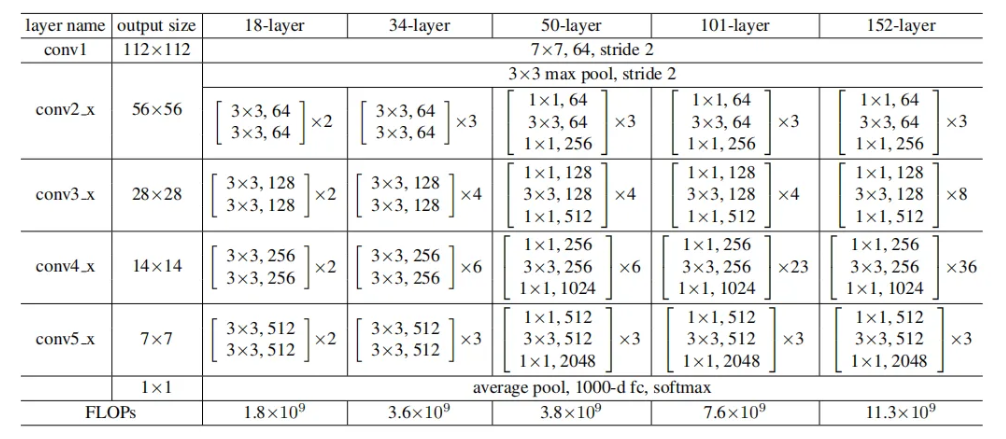

In [1]:
!pip install torchview

In [2]:
import torch
import torch.nn as nn
#import Ipython.display as Image
import torchvision
from torchview import draw_graph
device =torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available", device)
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU")

GPU is available cuda


Here, model_parameters[‘resnet50’] = ([64,128,256,512],[3,4,6,3],4,True) represents the parameters for resnet-50 where  

[64,128,256,512] -> channels in each intermediate block  
[3,4,6,3] -> # repeatition for Bottlenecks in each block  
4 -> expansion_factor. Note that 64 turns to 256, 128 to 512. All the resnet
 layers use the same expansion factor.  
True -> create Bottleneck layer status. True only for ResNet 50+  


In [4]:
# resnetX = (Num of channels, repetition, Bottleneck_expansion , Bottleneck_layer)
# resnetX = (Num of channels, repetition, Bottleneck_expansion , Bottleneck_layer)
model_parameters={}
model_parameters['resnet18'] = ([64,128,256,512],[2,2,2,2],1,False)
model_parameters['resnet34'] = ([64,128,256,512],[3,4,6,3],1,False)
model_parameters['resnet50'] = ([64,128,256,512],[3,4,6,3],4,True)
model_parameters['resnet101'] = ([64,128,256,512],[3,4,23,3],4,True)
model_parameters['resnet152'] = ([64,128,256,512],[3,8,36,3],4,True)

A bottleneck layer is a layer that contains few nodes compared to the previous layers. It can be used to obtain a representation of the input with reduced dimensionality.  
Bottlenecks are the bulding units of ResNet architecture. In the representation table above, big brackets [] contain details about the bottleneck details which are repeated few time to create 4 different blocks (conv2_x,conv3_x,conv4_x & conv5_x).  
Bottleneck is used to reduce the computation cost for layers-50,101 & 152. For resnet-18/34, BasicBlocks were used instead of bottleneck.
Bottleneck consists of (conv1x1->BN->relu) -> (conv3x3->BN->relu) -> (conv1x1->BN) ->relu where (1x1, 3x3 etc are kernel size)  

 * ❗***Bottleneck layer*** achieves to make the network more computationally efficient while maintaining its performance by reducing and then restoring the number of feature channels through a sequence of 1x1, 3x3, and 1x1 convolutions.
 * ***skip connections*** are used extensively in residual blocks to the point just prior to the final ReLU activation. a skip connection adds the input of a layer directly to the output of a deeper layer help maintain gradients at reasonable levels, allowing the network to learn more effectively.In very deep networks, gradients can become extremely small (or vanish).https://chatgpt.com/c/e2e673d5-f329-4505-b260-7f5fd7cc0159



In [5]:
class Bottleneck(nn.Module):
  def __init__(self,in_channels,intermediate_channels,expansion,is_Bottleneck,stride):
      super(Bottleneck,self).__init__()
      self.in_channels = in_channels
      self.intermediate_channels = intermediate_channels
      self.expansion = expansion
      self.is_Bottleneck = is_Bottleneck
      self.stride = stride
      self.relu = nn.ReLU()
      # i.e. if dim(x) == dim(F) => Identity function
      if self.in_channels==self.intermediate_channels*self.expansion:
              self.identity = True
      else:
              self.identity = False
              projection_layer = []
              projection_layer.append(nn.Conv2d(in_channels=self.in_channels, out_channels=self.intermediate_channels*self.expansion, kernel_size=1, stride=stride, padding=0, bias=False ))
              #normalize the outputs for maintaining stable and consistent activation distributions throughout the network for easy convergence
              projection_layer.append(nn.BatchNorm2d(self.intermediate_channels*self.expansion))
              # Only conv->BN and no ReLU
              # projection_layer.append(nn.ReLU())
              self.projection = nn.Sequential(*projection_layer)
      # is_Bottleneck = True for all ResNet 50+
      if self.is_Bottleneck:
            # bottleneck
            # 1x1
            self.conv1_1x1 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False )
            self.batchnorm1 = nn.BatchNorm2d(self.intermediate_channels)

            # 3x3
            self.conv2_3x3 = nn.Conv2d(in_channels=self.intermediate_channels, out_channels=self.intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False )
            self.batchnorm2 = nn.BatchNorm2d(self.intermediate_channels)

            # 1x1
            self.conv3_1x1 = nn.Conv2d(in_channels=self.intermediate_channels, out_channels=self.intermediate_channels*self.expansion, kernel_size=1, stride=1, padding=0, bias=False )
            self.batchnorm3 = nn.BatchNorm2d( self.intermediate_channels*self.expansion )

      else:
            # basicblock
            # 3x3
            self.conv1_3x3 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False )
            self.batchnorm1 = nn.BatchNorm2d(self.intermediate_channels)

            # 3x3
            self.conv2_3x3 = nn.Conv2d(in_channels=self.intermediate_channels, out_channels=self.intermediate_channels, kernel_size=3, stride=1, padding=1, bias=False )
            self.batchnorm2 = nn.BatchNorm2d(self.intermediate_channels)

  def forward(self,x):
        # input stored to be added before the final relu
        in_x = x
        if self.is_Bottleneck:
            # conv1x1->BN->relu
            x = self.relu(self.batchnorm1(self.conv1_1x1(x)))
            # conv3x3->BN->relu
            x = self.relu(self.batchnorm2(self.conv2_3x3(x)))
            # conv1x1->BN
            x = self.batchnorm3(self.conv3_1x1(x))
        else:
            # conv3x3->BN->relu
            x = self.relu(self.batchnorm1(self.conv1_3x3(x)))
            # conv3x3->BN
            x = self.batchnorm2(self.conv2_3x3(x))

        # identity or projected mapping
        if self.identity:
            x += in_x
        else:
            x += self.projection(in_x)
        # final relu
        x = self.relu(x)
        return x

  # Bottleneck(64*4,64,4,stride=1)
def test_bottleneck():
    x = torch.randn(1, 64, 112, 112)
    model = Bottleneck(64, 64, 4, True, 2)
    print(model(x).shape)
    del model

test_bottleneck()



torch.Size([1, 256, 56, 56])


In [7]:
class ResNet(nn.Module):

  def __init__(self, resnet_variant,in_channels,num_classes):
    super(ResNet, self).__init__()
    self.channels_list = resnet_variant[0] #Number of channels in different stages of network
    self.repeatition_list = resnet_variant[1] # Number of repeating residual blocks
    # ratio by which the number of channels is expanded within the residual
    # blocks compared to the input channels
    self.expansion = resnet_variant[2] #expansion factor
    self.is_Bottleneck = resnet_variant[3]

    #initial convolution layer
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False )
    self.batchnorm1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

    # residual blocks layers: In ResNet, after the initial stage, blocks of residual connections are often used
    # instead of plain convolutional layers.These residual blocks contain multiple convolutional layers and shortcut connections,
    # allowing the network to learn more complex representations while mitigating the vanishing gradient problem.
    self.block1 = self._make_blocks(64, self.channels_list[0], self.repeatition_list[0], self.expansion, self.is_Bottleneck, stride = 1)
    self.block2 = self._make_blocks(self.channels_list[0]*self.expansion, self.channels_list[1], self.repeatition_list[1], self.expansion, self.is_Bottleneck, stride =2)
    self.block3 = self._make_blocks(self.channels_list[1]*self.expansion, self.channels_list[2], self.repeatition_list[2], self.expansion, self.is_Bottleneck, stride =2)
    self.block4 = self._make_blocks(self.channels_list[2]*self.expansion, self.channels_list[3], self.repeatition_list[3], self.expansion, self.is_Bottleneck, stride =2)

    # to aggregate spatial information across the entire feature maps before passing them to the FC layers.
    # its exact placement may vary depending on the specific implementation and architectural choices made by the designers.
    self.average_pool = nn.AdaptiveAvgPool2d(1) #spatial dimensionality reduction before the FC layers
    self.fc1 = nn.Linear( self.channels_list[3]*self.expansion , num_classes)


  def _make_blocks(self, in_channels, intermediate_channels,num_repitions, expansion, is_Bottleneck, stride):
    layers = []
    layers.append(Bottleneck(in_channels,intermediate_channels,expansion,is_Bottleneck,stride=stride))
    for i in range(1, num_repitions):
      # The in_channels for subsequent layers should remain the same for basic blocks
      layers.append(Bottleneck(intermediate_channels, intermediate_channels, expansion, is_Bottleneck, stride=1)) #Fixed the in_channels for subsequent layers
    return nn.Sequential(*layers)

  def forward(self,x):

    x = self.relu(self.batchnorm1(self.conv1(x)))
    x = self.maxpool(x)
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.average_pool(x)
    x = torch.flatten(x, start_dim =1)
    x = self.fc1(x)
    return x
# Define model parameters
model_parameters = {
    'resnet18': [
        [64, 128, 256, 512],  # channels_list
        [2, 2, 2, 2],         # repeatition_list
        1,                    # expansion factor
        False                 # is_Bottleneck
    ]
}

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def test_ResNet(params):

    model = ResNet( params , in_channels=3, num_classes=1000)
    model.to(device)
    x = torch.randn(1,3,224,224).to(device)
    output = model(x)
    print(output.shape)
    return model

architecture = 'resnet18'
model = test_ResNet(model_parameters[architecture])



Using device: cuda
torch.Size([1, 1000])


Skip Connections: Allow gradients to flow through the network more easily, facilitating training of very deep networks.  
Bottleneck Design: Reduces computational complexity while maintaining representational power in deeper networks.  
Flexible Architecture: Can be adapted to different depths (e.g., ResNet-18, ResNet-34, ResNet-50, ResNet-101, ResNet-152) based on the number of residual blocks.  
Adaptive Average Pooling: Provides a fixed-size output regardless of the input size before the final fully connected layer.  